# Stacking and Finalizing

This notebook will use different machine learning models to improve the quality of the predictions.


In [3]:
# import from df from other notebook
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [4]:
%store -r df
%store -r df_scaled
%store -r df_interesting
%store -r df_interesting_scaled
%store -r df_full_info
%store -r df_all_rows


# Stacking Function

Like usual we are splitting the dataset and balancing it. After that we train 4 different machine learning models. Their prediction goes into another machine learning model, which makes a final prediciton.

In [5]:
def get_model(df): 
    # get X and y values
    X = df.drop("TARGET", axis=1)
    y = df["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

    balance = RandomUnderSampler('auto', random_state=42)
    balance_df = balance.fit_resample(X_train,y_train)
    X_train = balance_df[0]
    y_train = np.array(balance_df[1])





    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])


    numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['TARGET'], axis=1).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])



    # normalizing the training data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # defining the machine models
    models = [
        LogisticRegression(class_weight="balanced"),

        RandomForestClassifier(n_jobs=-1
                                       , n_estimators=300
                                       , max_depth=3
                                       , random_state=42),

        XGBClassifier(n_estimators=100
                           , random_state=42
                           , learning_rate=0.1),
        AdaBoostClassifier(n_estimators=100
                       , random_state=42
                       , learning_rate=1.0)
    ]
    # get the train and test data for the blender model
    S_train, S_test = stacking(models,                   

                               X_train, y_train, X_test,   

                               regression=False, 

                               mode='oof_pred_bag', 

                               needs_proba=False,

                               save_dir=None, 

                               metric=roc_auc_score, 

                               n_folds=4, 

                               stratified=True,

                               shuffle=True,  

                               random_state=42,    

                               verbose=2)
    # defining blender model
    model = XGBClassifier(random_state=42
                          , n_jobs=-1
                          , learning_rate=0.1
                          , n_estimators=100
                          , max_depth=3)

    # training of blender model and returning the data
    model = model.fit(S_train, y_train)
    y_pred = model.predict(S_test)
    y_prob = model.predict_proba(S_test)
    
    return {"blender": model,"S_test": S_test,"y_test": y_test,"y_pred": y_pred,"y_prob": y_prob}
    

In [6]:
df_set = [df, df_interesting, df_all_rows, df_full_info]

In [7]:
model_collections = []
for df in df_set:
    model_collections.append(get_model(df))
    
    
    

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [LogisticRegression]
    fold  0:  [0.66333548]
    fold  1:  [0.66537718]
    fold  2:  [0.66286673]
    fold  3:  [0.66588025]
    ----
    MEAN:     [0.66436491] + [0.00128697]
    FULL:     [0.66436516]

model  1:     [RandomForestClassifier]
    fold  0:  [0.66097142]
    fold  1:  [0.66612938]
    fold  2:  [0.66050156]
    fold  3:  [0.66770895]
    ----
    MEAN:     [0.66382782] + [0.00314577]
    FULL:     [0.66382784]

model  2:     [XGBClassifier]
    fold  0:  [0.66860090]
    fold  1:  [0.66913819]
    fold  2:  [0.66867036]
    fold  3:  [0.67608995]
    ----
    MEAN:     [0.67062485] + [0.00316203]
    FULL:     [0.67062490]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.66634429]
    fold  1:  [0.66569955]
    fold  2:  [0.66555430]
    fold  3:  [0.67243586]
    ----
    MEAN:     [0.66750850] + [0.00286031]
    FULL:     

/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  0:  [0.66441006]


/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  1:  [0.67053514]


/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  2:  [0.67146398]


/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  3:  [0.67028641]
    ----
    MEAN:     [0.66917390] + [0.00278520]
    FULL:     [0.66917414]

model  1:     [RandomForestClassifier]
    fold  0:  [0.66355040]
    fold  1:  [0.66688158]
    fold  2:  [0.66512364]
    fold  3:  [0.66942767]
    ----
    MEAN:     [0.66624582] + [0.00218248]
    FULL:     [0.66624577]

model  2:     [XGBClassifier]
    fold  0:  [0.67182463]
    fold  1:  [0.67010531]
    fold  2:  [0.67587120]
    fold  3:  [0.67737907]
    ----
    MEAN:     [0.67379505] + [0.00294331]
    FULL:     [0.67379507]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.66978294]
    fold  1:  [0.67085751]
    fold  2:  [0.67039010]
    fold  3:  [0.67651961]
    ----
    MEAN:     [0.67188754] + [0.00270133]
    FULL:     [0.67188759]

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [LogisticRegression]
    fold  0:  [0.69046480]
    fold  1:  [0.63925109]
    fold  2: 

In [8]:
from sklearn.metrics import roc_curve


In [9]:
def roc_scores(model, y_test, y_prob):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    return fpr, tpr, thresholds


In [10]:
#getting from the first model the fpr, tpr and thresholds

fpr_df , tpr_df, thresholds_df = roc_scores(model_collections[0]["blender"],model_collections[0]["y_test"],model_collections[0]["y_prob"][:,1] )

roc_scores(model_collections[0]["blender"],model_collections[0]["y_test"],model_collections[0]["y_prob"][:,1] )
model_collections[0]["y_prob"][:,1]


array([0.6968547 , 0.5970971 , 0.6968547 , ..., 0.31350285, 0.6968547 ,
       0.31350285], dtype=float32)

# Calculating the perfomance metric

The perfomance metric is the ROC-AUC Score as mentioned in the beginning.

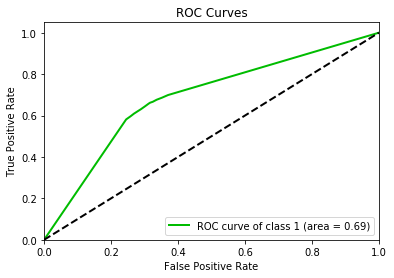

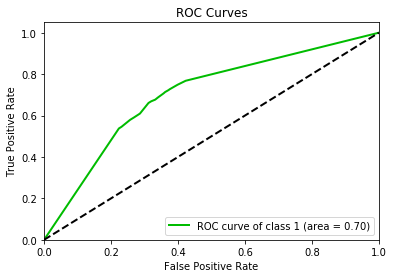

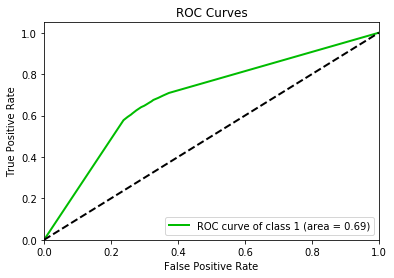

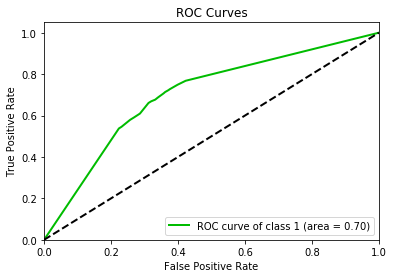

In [11]:
import scikitplot as skplt
import matplotlib.pyplot as plt

for i in range(len(model_collections)):
    y_test = model_collections[i]["y_test"]
    y_prob = model_collections[i]["y_prob"]
    
    skplt.metrics.plot_roc(y_test, y_prob, plot_micro=False,plot_macro=False,classes_to_plot=[1])

    plt.show()

## Threshold Calculation and Interpretation

In [21]:
# function for getting the thresholds
def calc_threshold(scores):
    results = []
    for i in np.arange(0.1, 1, 0.01):
        binary_probs = [(int(0)) if x < i else int(1) for x in scores]
        results.append(binary_probs)
    return results

In [23]:
# example of dataset 3
y_prob = model_collections[3]["y_prob"][:,1]
y_test = model_collections[3]["y_test"]
threshold_results = calc_threshold(y_prob)



In [24]:
cm_col_1 = []
for i, j in enumerate(threshold_results):
    cm_col_1.append(confusion_matrix(y_test, j))
cm_col_1

[array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[   0, 6781],
        [   0,  625]]),
 array([[4052, 2729],
        [ 137,  488]]),
 array([[4052, 2729],
        [ 13

In [25]:
# calculating the revenue
AMT_CREDIT_AVG = df['AMT_CREDIT'].mean()
pi = 3.141592

def feed_me(cm):
    return [item for sublist in cm for item in sublist]
revenue_list=[]
for cm in cm_col_1:
    tn, fp, fn, tp = feed_me(cm)
    total_n = sum(feed_me(cm))
    #print(tn,fp,fn,tp)
    actual_earnings = (tn * (2 * pi/100) * AMT_CREDIT_AVG)

    actual_loss = fn * AMT_CREDIT_AVG
    not_realized_earnings = (fp * (2 * pi/100) * AMT_CREDIT_AVG)
    not_realized_loss = tp * AMT_CREDIT_AVG
    revenue = actual_earnings - actual_loss
    revenue_list.append(revenue/total_n)
    print('\nActual Earnings:', actual_earnings), #print(tn)
    print('Actual Loss:', actual_loss), #print(fn)
    print('Not realized Earnings:', not_realized_earnings), #print(fp)
    print('\nRevenue:', revenue)
    print('Per credit:', revenue/total_n)
    print('\nPrevented Damage:', not_realized_loss), #print(tp)
    



Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0

Prevented Damage: 368081092.2678324

Actual Earnings: 0.0
Actual Loss: 0.0
Not realized Earnings: 250921002.53099632

Revenue: 0.0
Per credit: 0.0



In [27]:
# a profit orientated organization would look for maximum revenue per credit
revenue_list[np.argmax(revenue_list)]

9351.197317701406

In [ ]:
revenue_list
cm_col_1

In [ ]:
# a profit oriented company would maximize the revenue
# we want to give as many credits as possible while not making loss
# profit oriented company would approve in this case 20 % less loans than we would do
5296/4281

# Conclusion

- With our model we can make a better prediciton for people who might not pay back
- Therefore we can give more potential and trustful customers a credit
- Data could be biased as there was already a selection on the approved credit customers
- A profit oriented organization would do 

# Future Work

- multiple notebooks need abstraction
- improve reusability of the code
- improve models
- tune hyperparameters